# Alignment of DNA to RNA MERFISH segmentation

In [1]:
# Need to install ImageAnalysis3 and run the appropriate Startup_py3.py
%run "C:\Users\cosmosyw\Documents\Softwares\ImageAnalysis3\required_files\Startup_py3.py"
# append path to import ImageAnalysis3
sys.path.append(r"C:\Users\cosmosyw\Documents\Softwares")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

24568


## 0.1 Folders

In [2]:
save_folder = r'E:\DNA_analysis\20220819_Mecp2_DNA_from_0809'
pre_process_folder = r'Z:\Cosmos_DNA\MeC2_0809_DNA_preprocessed'

save_filenames = [os.path.join(pre_process_folder, _fl) for _fl in os.listdir(pre_process_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0508')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

243 fovs detected
Creating segmentation_folder: E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Segmentation
Creating cand_spot_folder: E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\CandSpots
Creating decoder_folder: E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Decoder
Creating picked_folder: E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Picked_v0


In [3]:
save_fov_ids = save_fov_ids[:] # [:20] is fov 120-139
save_filenames = save_filenames[:]

pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Translate segmentation

## 1.1 load rotation

In [4]:
# generate alignment
dna_data_folder = r'\\KOLMOGOROV\Chromatin_NAS_7\20220819_Mecp2_DNA_from_0809'
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_6\20220809_MOp_Mecp2_M2B'

# the 10x_position files contain 10 references points in the tissue during RNA and DNA MERFISH imaging for coarse alignment
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(dna_data_folder, 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_6\20220809_MOp_Mecp2_M2B\Alignment\10x_positions_before.txt 
 \\KOLMOGOROV\Chromatin_NAS_7\20220819_Mecp2_DNA_from_0809\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99989706  0.01434794]
 [-0.01434794  0.99989706]],
 translation:[-1523.66261536  -364.8612386 ]
-- rotation matrix saved to file:E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\rotation.npy
-- translation matrix saved to file:E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\translation.npy


# 1.2 save DAPI image for RNA

In [9]:
# MERFISH segmentation info
merfish_segmentation_folder = r'E:\MERFISH\MERFISH_analysis_full_z\Mecp2_0809\CellPoseSegment_full_z_DAPI\features'
merfish_dapi_folder = os.path.join(analysis_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    print(merfish_dapi_folder)
    os.makedirs(merfish_dapi_folder)

E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Merfish_DAPI


In [10]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 244


In [11]:
import multiprocessing as mp
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'
overwrite_dapi = False

# prepare args
dapi_args = []
for _fov_id, _fov_name in enumerate(rna_fovs):
    if _fov_id not in save_fov_ids:
        continue
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _dapi_filename = os.path.join(ref_fd, _fov_name)
        dapi_args.append((_dapi_filename, correction_folder, ['405'], '488', '405', True, True, True))
        
print(len(dapi_args))

243


In [ ]:
from ImageAnalysis3.classes.preprocess import batch_process_image_quick

print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(12) as _dapi_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    dapi_ims = _dapi_pool.starmap(batch_process_image_quick, dapi_args[:], chunksize=1)
    # close multiprocessing
    _dapi_pool.close()
    _dapi_pool.join()
    _dapi_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

In [ ]:
overwrite_dapi = False
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

i = 0

for _fov_id, _fov_name in enumerate(rna_fovs):
    if _fov_id in save_fov_ids:
        _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
        if overwrite_dapi or not os.path.exists(_dapi_savefile):
            if len(dapi_ims[i])>0:
                _dapi_im = dapi_ims[i][0]
                i += 1 # count the indices
                np.save(_dapi_savefile.split('.npy')[0], _dapi_im)
                print(f'Directly saved files for fov_{_fov_id} from multiprocessing.')
            else:
                # load 
                _dapi_filename = os.path.join(ref_fd, rna_fovs[_fov_id])
                _ref_cls = ia.classes.preprocess.DaxProcesser(_dapi_filename, 
                                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
                _ref_cls._load_image(sel_channels=[405])
                #_ref_cls._corr_hot_pixels_3D(correction_channels=[405])
                _ref_cls._corr_illumination(correction_channels=[405])
                _dapi_im = _ref_cls.im_405
                # save
                np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

In [ ]:
del dapi_ims

## 1.3 Prepare args

In [12]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r"C:\Users\cosmosyw\Documents\Softwares\MERlin_parameters\microscope\storm6_microscope.json"
dna_microscope_file = r"C:\Users\cosmosyw\Documents\Softwares\MERlin_parameters\microscope\storm6_microscope.json"
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = True
plot_segmentation = True

In [13]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

243
CPU times: total: 15.6 ms
Wall time: 120 ms


## 1.4 test run and plot

In [14]:
%matplotlib notebook
import sys
sys.path.append(r'C:\Users\cosmosyw\Documents\Softwares')

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ -0.5 -34.3  10.5] in 1.367s.
-- drift 1: [ -1.6 -33.7   9.9] in 1.262s.
--- drifts for crops:[0 1 2 3] pass the thresold, exit cycle.
--- drift: [ -1.05 -34.    10.2 ] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


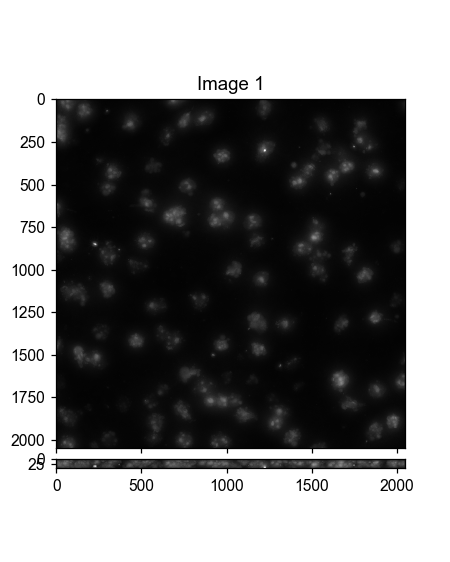

In [16]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 24
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1])

visual_tools.imshow_mark_3d_v2([_dna_dapi, dna_mask])

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ 0.8 -8.  -6.4] in 1.143s.
-- drift 1: [  1.2 232.2 246. ] in 1.247s.
-- drift 2: [ 0.3 -8.2 -7. ] in 1.147s.
-- drift 3: [ 0.4 -7.4 -6.2] in 1.256s.
-- drift 4: [ 0.6 -7.8 -6.5] in 1.175s.
-- drift 5: [ 0.1 -7.6 -6.7] in 1.156s.
-- drift 6: [ 0.6 -7.6 -6.3] in 1.125s.
-- drift 7: [ 0.1 -7.7 -6.9] in 1.167s.
-- return a sub-optimal drift
--- drift: [ 0.8 -8.  -6.4] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


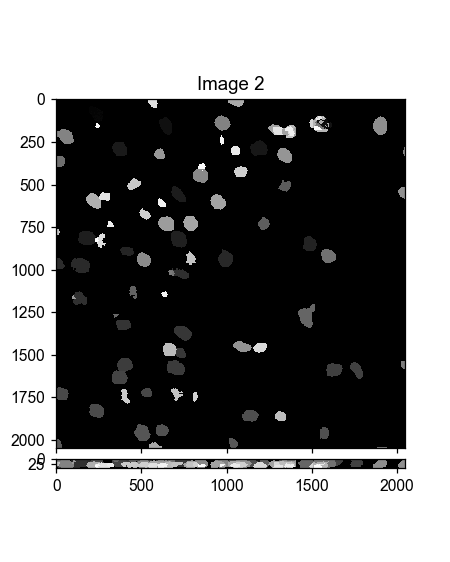

In [17]:
sel_fov = 102

_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1])

visual_tools.imshow_mark_3d_v2([_dna_dapi, dna_mask])

## 1.5 batch run translation

In [18]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(3) as _seg_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 2663.380s. 
CPU times: total: 109 ms
Wall time: 44min 23s
